In [7]:
import matplotlib.pyplot as plt
import geopandas as gdp
from matplotlib.animation import FuncAnimation
from highlight_text import fig_text, ax_text
from pypalettes import load_cmap
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

def draw_arrow(tail_position, head_position, invert=False, radius=0.5, color='black', fig=None):
   if fig is None:
      fig = plt.gcf()
   kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color=color, lw=0.5)
   if invert:
      connectionstyle = f"arc3,rad=-{radius}"
   else:
      connectionstyle = f"arc3,rad={radius}"
   a = FancyArrowPatch(
      tail_position, head_position,
      connectionstyle=connectionstyle,
      transform=fig.transFigure,
      **kw
   )
   fig.patches.append(a)

def create_legend_elements(cmap, value_ranges, labels):
   legend_elements = []
   n = len(value_ranges)
   for i in range(n-1):
      value = (value_ranges[i] + value_ranges[i+1]) / 2 / value_ranges[-1]  # Normalize the value to [0, 1]
      legend_elements.append(Patch(facecolor=cmap(value), label=labels[i]))
   return legend_elements

# load the font
personal_path = '/Users/josephbarbier/Library/Fonts/'
font = FontProperties(fname=personal_path + 'BebasNeue-Regular.ttf')
other_font = FontProperties(fname=personal_path + 'FiraSans-Light.ttf')
other_bold_font = FontProperties(fname=personal_path + 'FiraSans-Medium.ttf')

min, max = 0, 25
norm = mcolors.Normalize(vmin=min, vmax=max)
background_color = 'white'
text_color = 'black'
value_ranges = [i for i in range (0, 28, 3)]
labels = [f"{i} - {i+2} t" for i in value_ranges[:-1]]
labels[-1] = '25+ t'

df = gdp.read_file('all_year.geojson')

start_year = 1950
df = df[df['year'] >= start_year]
df.head()

,country,co2Capita,year,geometry
130,Norway,2.569677,1950.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
131,Norway,2.874687,1951.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
132,Norway,2.909801,1952.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
133,Norway,2.910451,1953.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
134,Norway,2.910949,1954.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."


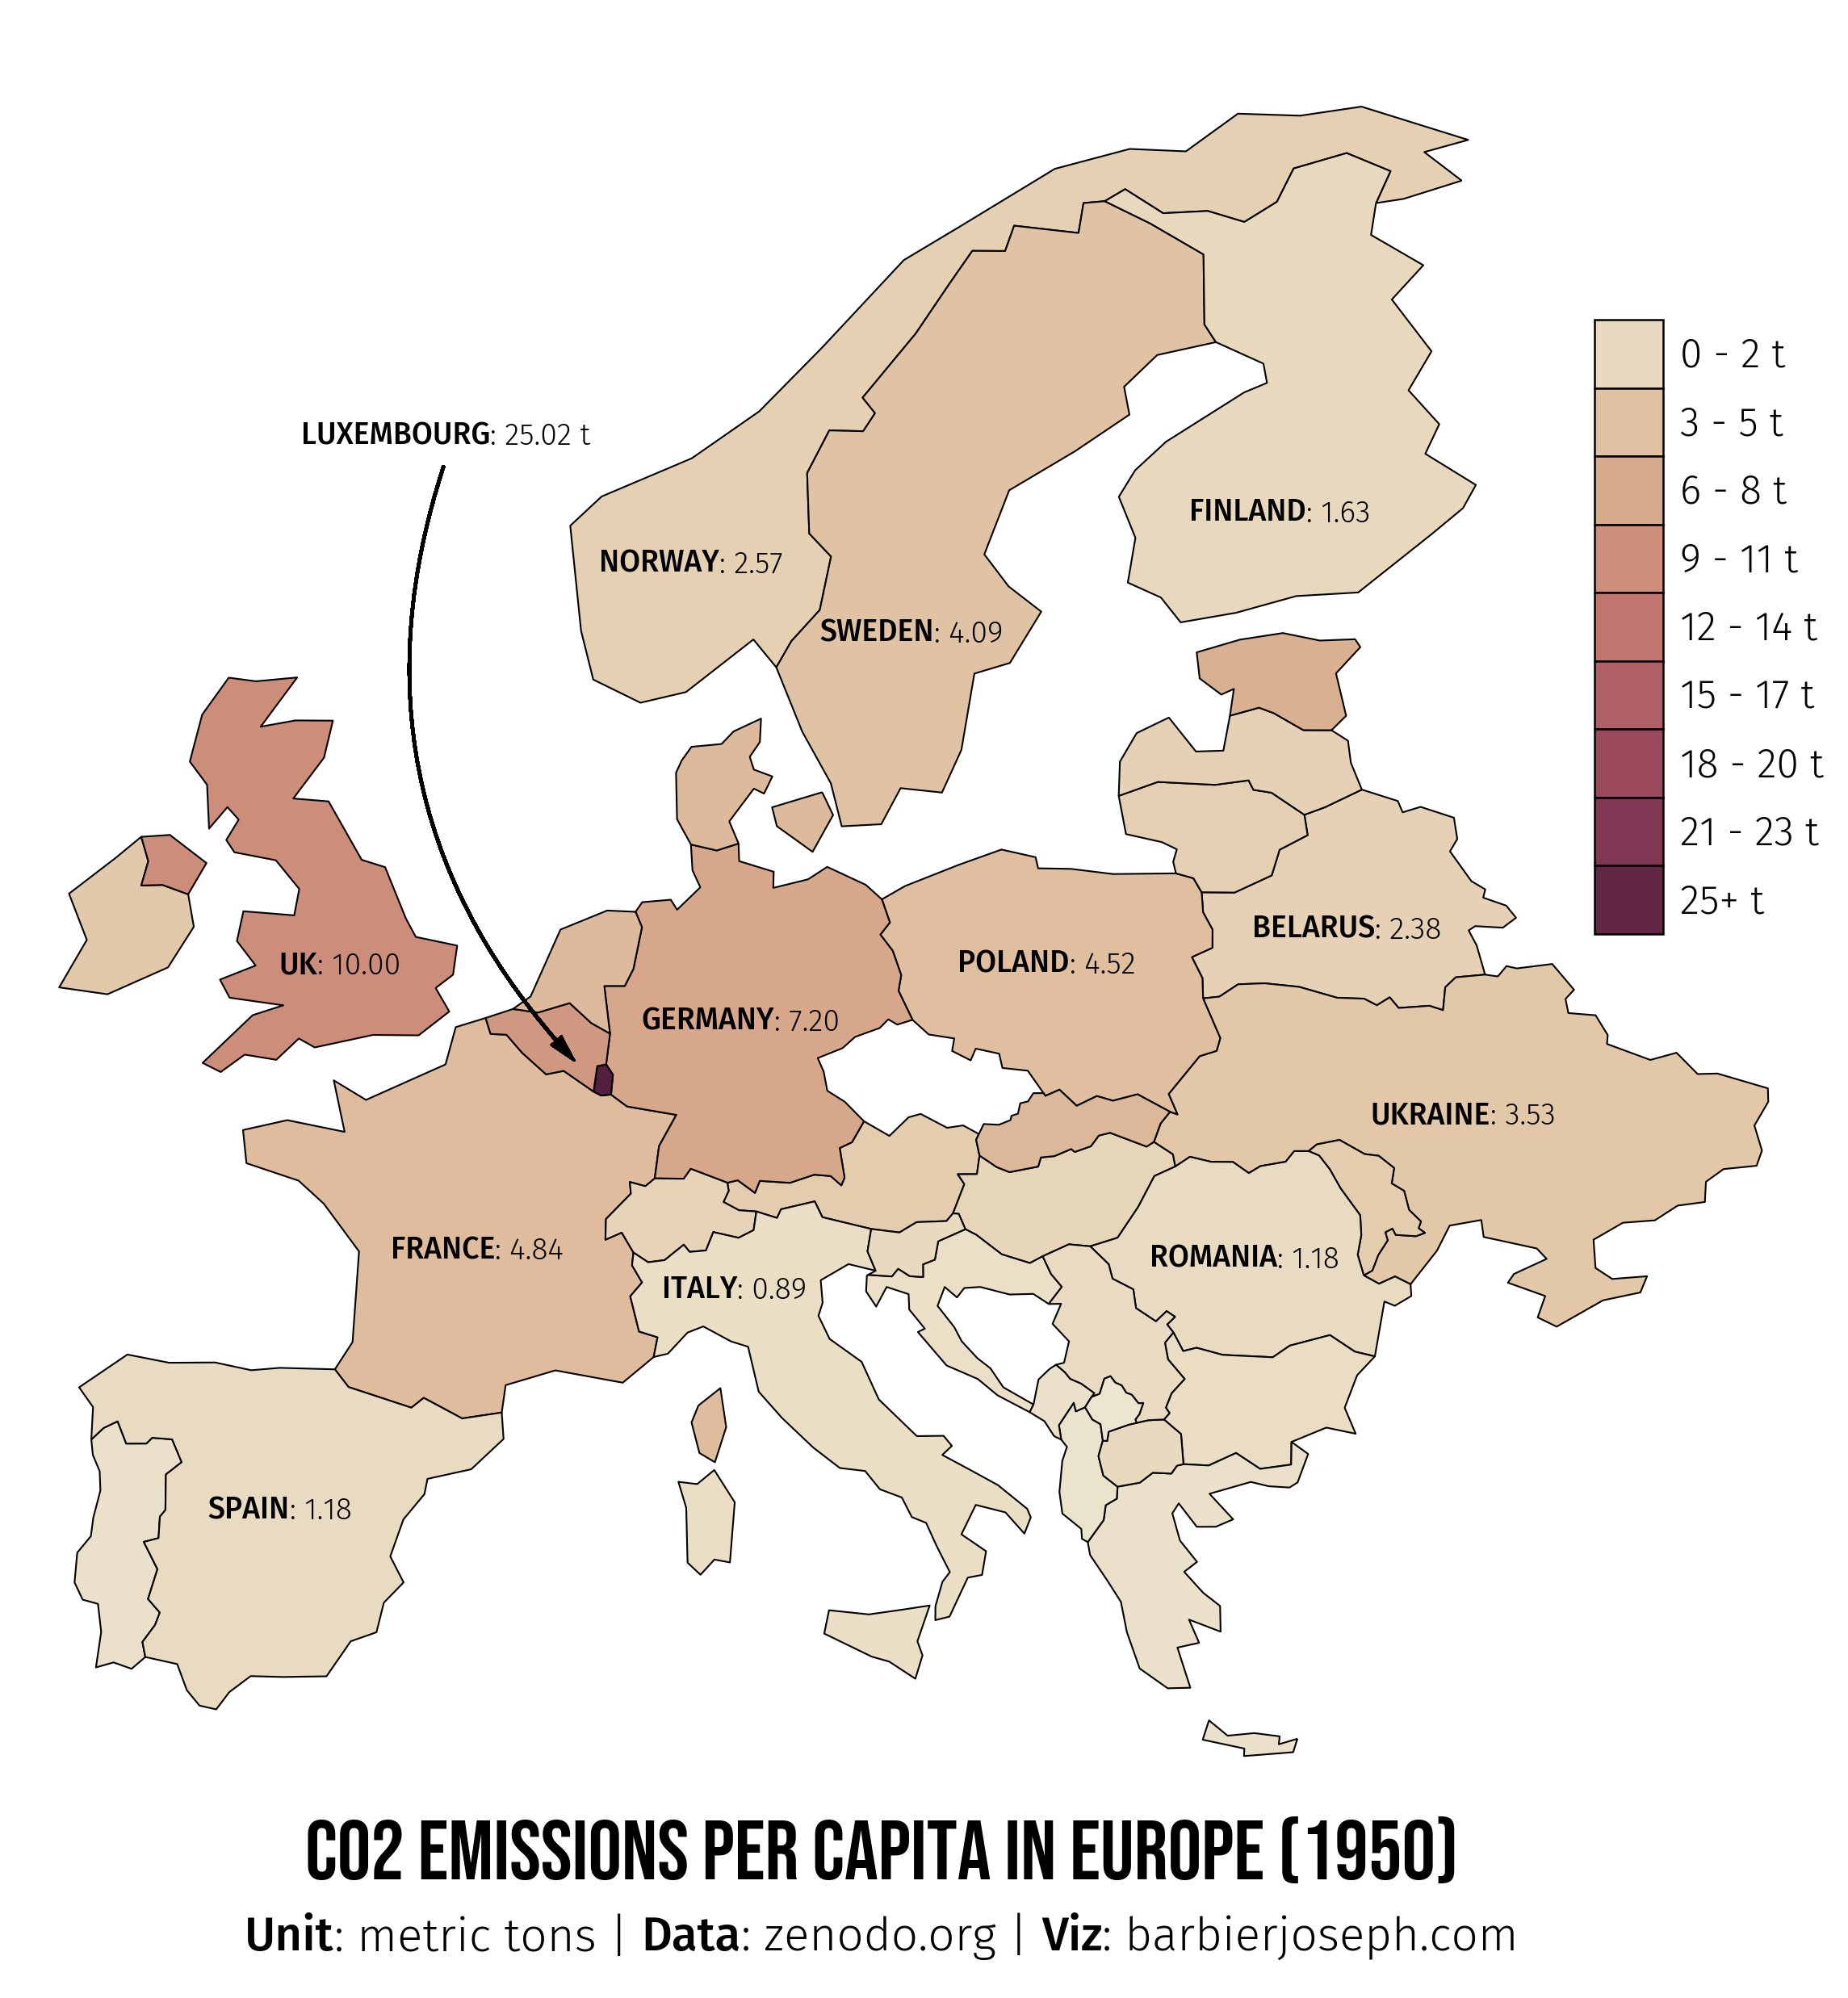

In [8]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

def update(year):

   ax.clear()
   cmap = load_cmap('BrwnYl', type='continuous')

   data = df[df['year']==year]

   # initialize the figure
   fig.set_facecolor(background_color)

   # create the plot
   data.plot(ax=ax, column='co2Capita', cmap=cmap, norm=norm, edgecolor='black', linewidth=0.5)

   # custom axis
   ax.set_xlim(-11, 41)
   ax.set_ylim(32, 73)
   ax.set_axis_off()

   # add the patches to the plot area as a legend
   legend_elements = create_legend_elements(cmap, value_ranges, labels)
   rectangle_width = 2
   rectangle_height = 1.5
   legend_x = 35
   legend_y_start = 65
   legend_y_step = 1.5
   for i, element in enumerate(legend_elements):
      ax.add_patch(plt.Rectangle((legend_x, legend_y_start - i * legend_y_step), rectangle_width, rectangle_height,
                                 color=element.get_facecolor(), ec='black', lw=0.6))
      ax.text(legend_x + 2.5, legend_y_start - i * legend_y_step + 0.7, element.get_label(), 
               fontsize=12, fontproperties=other_font, color=text_color, va='center')

   # compute centroids and display the total
   adjustments = {
      'France': (10.3, 3),
      'Italy': (-1.6, 2.5),
      'Lithuania': (0, -0.6),
      'Finland': (0, -2),
      'Romania': (0, 0),
      'Belarus': (0, -0.4),
      'Bulgaria': (0, 0),
      'Greece': (-1.2, -0.8),
      'Croatia': (0, -1),
      'Cyprus': (0, -1),
      'Ireland': (0, -1),
      'Malta': (0, -1),
      'Slovenia': (0, -1),
      'Slovakia': (-0.7, -0.8),
      'Estonia': (0, -0.7),
      'Latvia': (0, -0.5),
      'Belgium': (0, -0.7),
      'Austria': (0, -0.4),
      'Spain': (1, 0),
      'Portugal': (-0.5, -1),
      'Luxembourg': (0, -1),
      'Germany': (-0.2, 0),
      'Hungary': (-0.3, -1),
      'Czechia': (0, -1),
      'Poland': (0, 0.2),
      'Sweden': (-0.8, -2.8),
      'Denmark': (0, -1),
      'Netherlands': (0, 0),
      'United Kingdom': (2.2, -1.5),
      'Switzerland': (0, -0.5),
      'Norway': (-4, -5.5),
   }
   data_projected = data.to_crs(epsg=3035)
   data_projected['centroid'] = data_projected.geometry.centroid
   data['centroid'] = data_projected['centroid'].to_crs(data.crs)
   countries_to_annotate = data['country'].tolist()
   countries_to_annotate = [
      'France', 'Italy', 'Romania', 'Poland',
      'Finland', 'Ukraine',
      'Spain', 'Germany', 
      'Sweden', 'United Kingdom',
      'Belarus', 'Norway'
   ]
   for country in countries_to_annotate:
      try:
         centroid = data.loc[data['country'] == country, 'centroid'].values[0]
         x, y = centroid.coords[0]
         try:
            x += adjustments[country][0]
            y += adjustments[country][1]
         except KeyError:
            pass
         rate = data.loc[data['country'] == country, 'co2Capita'].values[0]
         if country=='United Kingdom':
            country = 'UK'
         if rate > 20:
            color_text = 'white'
         else:
            color_text = text_color
         ax_text(
            x=x-3, y=y, s=f"<{country.upper()}>: {rate:.2f}", fontsize=9, font=other_font, color=color_text,
            ha='left', va='center', ax=ax, highlight_textprops=[{'font': other_bold_font}]
         )
      except IndexError:
         pass

   # title
   fig_text(
      s=f"CO2 emissions per capita in Europe ({int(year)})", x=0.5, y=0.14,
      color=text_color, fontsize=25, font=font, ha='center', va='top', ax=ax
   )

   # subtitle
   fig_text(
      s="<Unit>: metric tons | <Data>: zenodo.org | <Viz>: barbierjoseph.com", x=0.5, y=0.1,
      color=text_color, fontsize=14, font=other_font, ha='center', va='top', ax=ax,
      highlight_textprops=[{'font': other_bold_font}, {'font': other_bold_font}, {'font': other_bold_font}]
   )

   # arrows for the Luxembourg
   luxembourg_values = data.loc[data['country'] == 'Luxembourg', 'co2Capita'].values[0]
   draw_arrow((0.32, 0.7), (0.375, 0.45), radius=0.3, fig=fig)
   fig_text(
      s=f"<LUXEMBOURG>: {luxembourg_values:.2f} t", x=0.32, y=0.71, highlight_textprops=[{'font': other_bold_font}],
      color=text_color, fontsize=9, font=other_font, ha='center', va='center', fig=fig
   )

   return ax

# create and save animation
path = 'co2-anim.gif'
ani = FuncAnimation(fig, update, frames=df['year'].sort_values().unique())
ani.save(path, fps=8)